In [9]:
import sys
import dill
import importlib

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../src')
import policies 
import bbDebiasing
import maxEnsembleDebias

sys.path.append('experiment-pipeline')
import analysisHelp
import dataGeneration

Comparison of final WB and BB Models

In [48]:
importlib.reload(analysisHelp)

pathA = ['linear-label_gb_coord_variance_5000_subsample400_BBModel.pkl',
'linear-label_gb_coord_variance_5000_subsample400_MaxEnsemble.pkl']
pathB = ['linear-label_gb_group_variance_5000_subsample400_BBModel.pkl',
'linear-label_gb_group_variance_5000_subsample400_MaxEnsemble.pkl']
pathC = ['linear-label_gb_coord_linear-constraint_5000_subsample400_BBModel.pkl',
'linear-label_gb_coord_linear-constraint_5000_subsample400_MaxEnsemble.pkl']
pathD = ['linear-label_gb_group_linear-constraint_8000_subsample400_BBModel.pkl',
'linear-label_gb_group_linear-constraint_8000_subsample400_MaxEnsemble.pkl']

pathsets = [pathA, pathB, pathC, pathD]
experimentNames = ["A","B","C","D"]



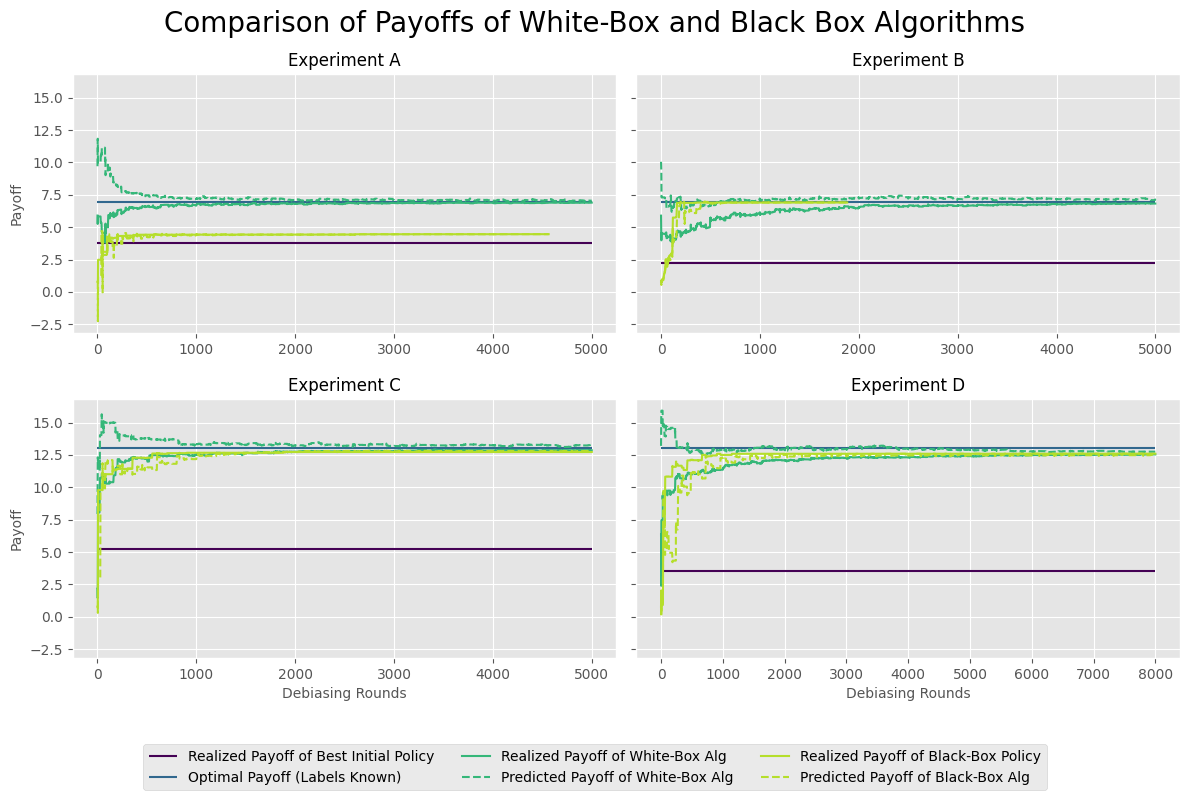

In [49]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):

    bbPath = f'experiment-pipeline/debiased-models/{pathsets[i][0]}'
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(bbPath, 'rb') as file:
        bbModel = dill.load(file)
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)

    BBpred_rev = np.mean(np.sum(np.multiply(bbModel.predictions_by_round, np.array(bbModel.policy_by_round)), axis=2), axis=1)
    BBreal_rev = np.mean(np.sum(np.multiply(np.tile(bbModel.train_y, (len(bbModel.policy_by_round),1,1)), np.array(bbModel.policy_by_round)), axis=2), axis=1)
    maxEnsemblereal_rev = np.mean(np.array(maxModel.realized_revs_by_round), axis=2)
    meta_real_rev = []
    meta_pred_rev = []
    for j in range(maxModel.curr_depth):
        meta_real_rev.append(np.mean(maxModel.realized_revs_by_round[j][maxModel.max_policy_index_by_round[j], np.arange(maxModel.n)]))
        meta_pred_rev.append(np.mean(maxModel.self_assessed_revs_by_round[j][maxModel.max_policy_index_by_round[j], np.arange(maxModel.n)]))

    max_init_model = max([maxEnsemblereal_rev[0,i] for i in range(maxModel.n_models)])

    if i==0:
        axs[i//2,i%2].hlines(max_init_model, 0, maxModel.curr_depth-1, label=f"Realized Payoff of Best Initial Policy", color=colors[0])
        axs[i//2,i%2].hlines(np.mean(np.einsum('ij, ij->i', maxModel.train_y, maxModel.policies[0].run_given_preds(maxModel.train_y))), 0, maxModel.curr_depth-1, label="Optimal Payoff (Labels Known)", color=colors[3])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_real_rev, label=f"Realized Payoff of White-Box Alg", color=colors[6])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_pred_rev, '--', label=f"Predicted Payoff of White-Box Alg", color=colors[6])
        axs[i//2,i%2].plot(np.arange(len(BBreal_rev[:-1])), BBreal_rev[:-1], label="Realized Payoff of Black-Box Policy", color=colors[8])
        axs[i//2,i%2].plot(np.arange(len(BBpred_rev[:-1])), BBpred_rev[:-1], '--', label="Predicted Payoff of Black-Box Alg", color=colors[8])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)
        
    else:
        axs[i//2,i%2].hlines(max_init_model, 0, maxModel.curr_depth-1, color=colors[0])
        axs[i//2,i%2].hlines(np.mean(np.einsum('ij, ij->i', maxModel.train_y, maxModel.policies[0].run_given_preds(maxModel.train_y))), 0, maxModel.curr_depth-1, color=colors[3])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_real_rev, color=colors[6])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_pred_rev, '--', color=colors[6])
        axs[i//2,i%2].plot(np.arange(len(BBreal_rev[:-1])), BBreal_rev[:-1], color=colors[8])
        axs[i//2,i%2].plot(np.arange(len(BBpred_rev[:-1])), BBpred_rev[:-1], '--', color=colors[8])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)

axs[0,0].set_ylabel('Payoff', fontsize=10)
axs[1,0].set_ylabel('Payoff', fontsize=10)
axs[1,0].set_xlabel('Debiasing Rounds', fontsize=10)
axs[1,1].set_xlabel('Debiasing Rounds', fontsize=10)

fig.suptitle("Comparison of Payoffs of White-Box and Black Box Algorithms", fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.9, bottom=0.17) 
fig.legend(loc='lower center', ncol=3)
plt.savefig('paper-figs/WBvsBB.pdf')

Comparison of initial and final model performance in sample

In [14]:
bbPath = f'experiment-pipeline/debiased-models/{pathsets[0][0]}'
wbPath = f'experiment-pipeline/debiased-models/{pathsets[0][1]}'
with open(bbPath, 'rb') as file:
    bbModel = dill.load(file)
with open(wbPath, 'rb') as file:
    maxModel = dill.load(file)

In [77]:
# in sample self assessed initial revenue
np.mean(maxModel.self_assessed_revs_by_round[0], axis=1)
#self.realized_revs_by_round

# out of sample self assessed initial revenue

array([5.5073774 , 6.48275033, 4.86014422, 4.58221973])

Generate holdout data

In [5]:

rng = np.random.default_rng(seed=42)

# Feature parameters
n = 11000
n_features = 20
cov_min = -3
cov_max = 3
mean_min = -5
mean_max = 5
num_categories = 5

xs = dataGeneration.feature_gen(n, n_features, cov_min, cov_max, mean_min, mean_max, num_categories)

# Label parameters
label_dim = 4
n_terms = 5
term_size = 2
coeff_min = -1
coeff_max = 1
max_exponent = 2
noise = 0.01

ys = dataGeneration.linear_label_gen(xs, label_dim, noise)

holdout_xs = xs[10000:]
holdout_ys = ys[10000:]

Get predictions of initial models on holdout

In [53]:
initial_model_vals = []
for model in maxModel.init_models:
    holdout_preds = model(holdout_xs)
    holdout_policy = maxModel.policies[0].run_given_preds(holdout_preds)
    holdout_pred_rev = np.mean(np.sum(np.multiply(holdout_preds, holdout_policy), axis=1))
    holdout_real_rev = np.mean(np.sum(np.multiply(holdout_ys, holdout_policy), axis=1))

    training_preds = model(maxModel.train_x)
    training_policy = maxModel.policies[0].run_given_preds(training_preds)
    training_pred_rev = np.mean(np.sum(np.multiply(training_preds, training_policy), axis=1))
    training_real_rev = np.mean(np.sum(np.multiply(maxModel.train_y, training_policy), axis=1))

    model_vals = {'holdout_pred_rev': holdout_pred_rev, 'holdout_real_rev': holdout_real_rev, 
     'training_pred_rev': training_pred_rev, 'training_real_rev': training_real_rev}
    initial_model_vals.append(model_vals)
    


Get final models predictions

In [63]:
import dill
import numpy as np
import sys

import dataGeneration

sys.path.append('../../src')
import policies 
import bbDebiasing
import maxEnsembleDebias

rng = np.random.default_rng(seed=42)

# Feature parameters
n = 11000
n_features = 20
cov_min = -3
cov_max = 3
mean_min = -5
mean_max = 5
num_categories = 5

xs = dataGeneration.feature_gen(n, n_features, cov_min, cov_max, mean_min, mean_max, num_categories)

# Label parameters
label_dim = 4
n_terms = 5
term_size = 2
coeff_min = -1
coeff_max = 1
max_exponent = 2
noise = 0.01

ys = dataGeneration.linear_label_gen(xs, label_dim, noise)

holdout_xs = xs[10000:10010]
holdout_ys = ys[10000:10010]

pathA = ['linear-label_gb_coord_variance_5000_subsample400_BBModel.pkl',
'linear-label_gb_coord_variance_5000_subsample400_MaxEnsemble.pkl']
pathB = ['linear-label_gb_group_variance_5000_subsample400_BBModel.pkl',
'linear-label_gb_group_variance_5000_subsample400_MaxEnsemble.pkl']
pathC = ['linear-label_gb_coord_linear-constraint_5000_subsample400_BBModel.pkl',
'linear-label_gb_coord_linear-constraint_5000_subsample400_MaxEnsemble.pkl']
pathD = ['linear-label_gb_group_linear-constraint_8000_subsample400_BBModel.pkl',
'linear-label_gb_group_linear-constraint_8000_subsample400_MaxEnsemble.pkl']

pathsets = [pathA, pathB, pathC, pathD]
experimentNames = ["A","B","C","D"]

for i in range(len(pathsets)):

    bbPath = f'experiment-pipeline/debiased-models/{pathsets[i][0]}'
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(bbPath, 'rb') as file:
        bbModel = dill.load(file)
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)
    
    bbPreds = bbModel.predict(holdout_xs)

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by GradientBoostingRegressor.